In [22]:
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.datasets import lorenz, doublescroll
from reservoirpy.observables import nrmse
from reservoirpy.nodes import Ridge, NVAR

%matplotlib inline

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [23]:
# Load your DataFrame (replace 'your_file.csv' with your actual file)
import pandas as pd


df_ibm = pd.read_csv('ibm_data/4.csv')

# Stack the columns into a numpy array with shape (n_samples, 6)
print(df_ibm.shape)  # Check the shape of the DataFrame
X = df_ibm.values.reshape(-1, 6)  # Reshape to (n_samples, 6)

print(X.shape)
print(X[:5])  # Show first 5 rows
X[:, 0::2] = X[:, 0::2] - 1204  # even columns: 1202
X[:, 1::2] = X[:, 1::2] - 1221  # odd columns: 1221
print(X[:5])


(17603, 6)
(17603, 6)
[[1201 1183  700 1491 1023 1805]
 [1202 1183  712 1509 1054 1802]
 [1202 1183  723 1526 1085 1798]
 [1203 1183  738 1544 1114 1791]
 [1203 1183  751 1561 1142 1786]]
[[  -3  -38 -504  270 -181  584]
 [  -2  -38 -492  288 -150  581]
 [  -2  -38 -481  305 -119  577]
 [  -1  -38 -466  323  -90  570]
 [  -1  -38 -453  340  -62  565]]


In [24]:

train_time  = 70.
# testing time (idem)
test_time   = 110.
# warmup time (idem): should always be > k * s
warm_time   = 20.

total_samples = X.shape[0]
print("Total samples:", total_samples)


trimmed_size = 17781
# discretization
train_steps = round(train_time * trimmed_size / (train_time + test_time + warm_time))
test_steps  = round(test_time  * trimmed_size / (train_time + test_time + warm_time))
warm_steps  = round(warm_time  * trimmed_size / (train_time + test_time + warm_time))

print("train_steps:", train_steps)
print("test_steps:", test_steps)
print("warm_steps:", warm_steps)

X = X[:train_steps + test_steps + warm_steps, -4:]


print("X shape:", X.shape)

Total samples: 17603
train_steps: 6223
test_steps: 9780
warm_steps: 1778
X shape: (17603, 4)


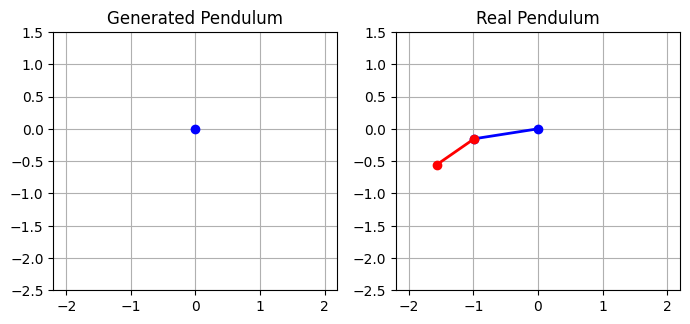

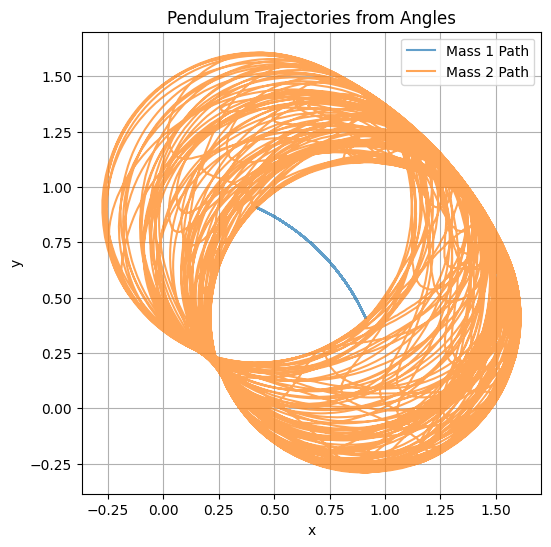

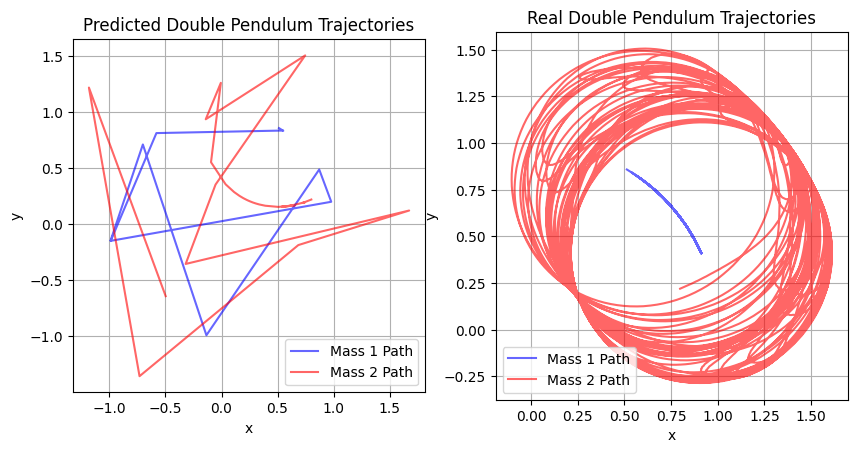

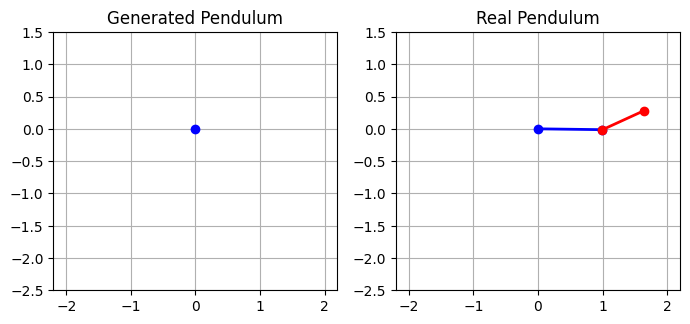

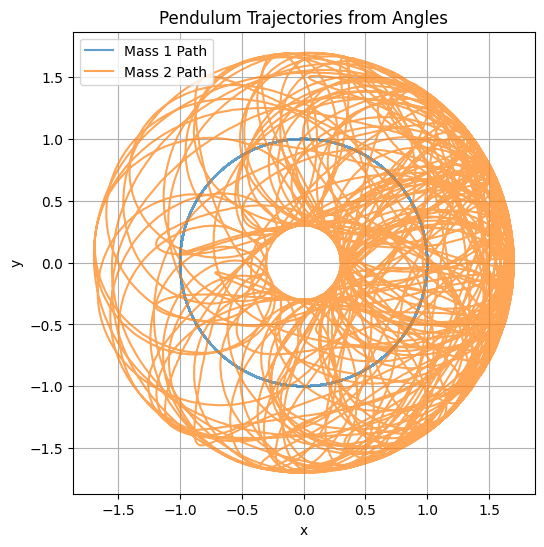

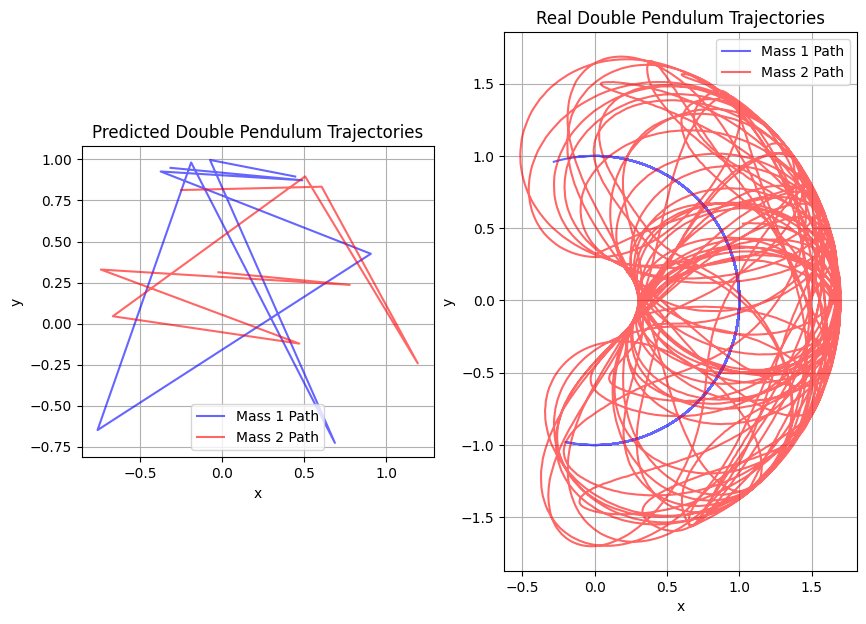

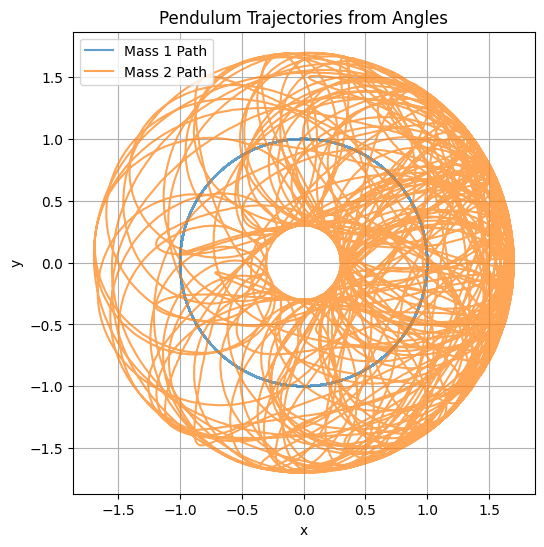

Training data shape: (17603, 4)
First 5 rows of training data:
 [[-2.0626055   2.3420667  -2.27592908 -3.78825004]
 [-2.10038593  2.27918175 -2.20795479 -3.82186368]
 [-2.1359096   2.21518083 -2.30460209 -3.83025505]
 [-2.17689871  2.15201728 -2.3717151  -3.68114232]
 [-2.21465054  2.0929669  -2.34214948 -3.60106944]]


In [25]:
def plot_xy_columns(data):
    """
    Plot trajectories for columns formatted as x1, y1, x2, y2, ..., xn, yn.
    Each (xi, yi) pair is plotted as a separate trajectory.
    """
    n_pairs = data.shape[1] // 2
    plt.figure(figsize=(8, 6))
    for i in range(n_pairs):
        x = data[:, 2*i]
        y = data[:, 2*i+1]
        plt.plot(x, y, label=f'Mass {i+1} Path', alpha=0.7)
    plt.title("Trajectories")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
#plot_xy_columns(X)


# Convert (x1, y1, x2, y2) to (t1, t2, o1, o2) for each row
# t1, t2: angles; o1, o2: angular velocities (finite difference)

def xy_to_angles(data, l1=1.0, l2=1.0):
    """
    Convert (x1, y1, x2, y2) to (theta1, theta2) for double pendulum.
    Assumes origin at (0,0), l1 and l2 are lengths.
    """
    x1, y1, x2, y2 = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
    th1 = np.arctan2(x1, -y1)
    th2 = np.arctan2(x2 - x1, -(y2 - y1))
    return th1, th2

def compute_angular_velocities(theta1, theta2, dt=0.0166):
    """
    Compute angular velocities o1, o2 using finite differences.
    """
    o1 = np.gradient(theta1, dt)
    o2 = np.gradient(theta2, dt)
    return o1, o2

# Example: convert X to (t1, t2, o1, o2)
t1, t2 = xy_to_angles(X)
o1, o2 = compute_angular_velocities(t1, t2)

# Stack into new array
angles_vels = np.column_stack([t1, t2, o1, o2])

def plot_from_theta(theta1, theta2, l1=1.0, l2=0.7, label_prefix=""):
    """
    Plot the (x, y) positions of a double pendulum from theta1, theta2 arrays.
    """
    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta2)
    y2 = y1 - l2 * np.cos(theta2)
    plt.figure(figsize=(8, 6))
    plt.plot(x1, y1, label=f'{label_prefix}Mass 1 Path', alpha=0.7)
    plt.plot(x2, y2, label=f'{label_prefix}Mass 2 Path', alpha=0.7)
    plt.title("Pendulum Trajectories from Angles")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_from_theta(t1, t2)


training_data = np.stack([t1,t2,o1,o2], axis=1)

print("Training data shape:", training_data.shape)
print("First 5 rows of training data:\n", training_data[:5])



In [43]:
# How to call the NVAR fix functions

# Assuming you have your data and parameters ready:
# training_data = your_double_pendulum_data  # shape: (timesteps, 4) for [theta1, theta2, omega1, omega2]
# warm_steps = 100  # or whatever you're using
# train_steps = 1000  # or whatever you're using  
# test_steps = 500   # or whatever you're using

# METHOD 1: Quick Fix (recommended first try)
def apply_quick_fix(training_data, warm_steps, train_steps, test_steps):
    """
    Apply the immediate fix to your existing code
    """
    import numpy as np
    from reservoirpy.nodes import Ridge, NVAR
    
    # 1. Normalize your data first
    data_mean = np.mean(training_data[:train_steps+warm_steps], axis=0)
    data_std = np.std(training_data[:train_steps+warm_steps], axis=0) 
    data_std = np.where(data_std == 0, 1, data_std)
    normalized_data = (training_data - data_mean) / data_std

    # 2. Fix the parameters
    nvar = NVAR(delay=2, order=2, strides=1)  # strides=1 instead of 2
    readout = Ridge(4, ridge=1e-5, input_bias=True)  # Add regularization!

    model = nvar >> readout

    # 3. Use normalized data
    Xi = normalized_data[:train_steps+warm_steps-1]
    dXi = normalized_data[1:train_steps+warm_steps] - normalized_data[:train_steps+warm_steps-1]

    print(f"Xi shape: {Xi.shape}, dXi shape: {dXi.shape}")

    model = model.fit(Xi, dXi, warmup=warm_steps)

    # 4. Prediction (same as before)
    nvar.run(normalized_data[warm_steps+train_steps-2:warm_steps+train_steps])
    u = normalized_data[warm_steps+train_steps]
    res = np.zeros((test_steps, readout.output_dim))
    for i in range(test_steps):
        u = u + model(u)
        res[i, :] = u

    # 5. Denormalize results
    res_final = res * data_std + data_mean
    
    return res_final, model

# METHOD 2: Use the comprehensive fix function
def use_comprehensive_fix(training_data, warm_steps, train_steps, test_steps):
    """
    Use the comprehensive fix that tries multiple approaches
    """
    # This tries all the solutions automatically
    model, results = fix_ill_conditioned_nvar(training_data, warm_steps, train_steps, test_steps)
    return model, results

# METHOD 3: Use specific fix functions
def use_specific_fixes(training_data, warm_steps, train_steps, test_steps):
    """
    Call specific fix functions individually
    """
    
    # Option A: Try proper ridge regularization
    model1, results1, ridge_val = fix_with_proper_ridge(training_data, warm_steps, train_steps, test_steps)
    if model1 is not None:
        print(f"Ridge regularization worked with ridge={ridge_val}")
        return model1, results1
    
    # Option B: Try simpler NVAR
    model2, config = fix_with_simpler_nvar(training_data, warm_steps, train_steps, test_steps)
    if model2 is not None:
        print(f"Simpler NVAR worked with config={config}")
        return model2, None
    
    # Option C: Try direct prediction
    model3, results3 = alternative_direct_prediction(training_data, warm_steps, train_steps, test_steps)
    if model3 is not None:
        print("Direct prediction worked")
        return model3, results3
    
    return None, None

# METHOD 4: Just diagnose the problem first
def diagnose_first(training_data, warm_steps, train_steps):
    """
    First understand what's wrong with your current setup
    """
    diagnose_ill_conditioning(training_data, warm_steps, train_steps)

# EXAMPLE USAGE:
if __name__ == "__main__":
    # Replace these with your actual data and parameters
    # training_data = your_data_here
    # warm_steps = your_warm_steps
    # train_steps = your_train_steps  
    # test_steps = your_test_steps
    
    print("Choose your approach:")
    print("1. Quick fix (recommended)")
    print("2. Comprehensive fix (tries everything)")
    print("3. Diagnose first")
    
    # OPTION 1: Quick fix (recommended first)
    # results, model = apply_quick_fix(training_data, warm_steps, train_steps, test_steps)
    
    # OPTION 2: Comprehensive fix
    # model, results = use_comprehensive_fix(training_data, warm_steps, train_steps, test_steps)
    
    # OPTION 3: Diagnose first
    # diagnose_first(training_data, warm_steps, train_steps)

# COPY-PASTE SOLUTION (easiest):
# Just replace your existing code with this:

"""
# Replace your current code with this:

import numpy as np
from reservoirpy.nodes import Ridge, NVAR

# Your existing data loading code here...
# training_data = ...
# warm_steps = ...
# train_steps = ...
# test_steps = ...

# 1. ADD DATA NORMALIZATION
data_mean = np.mean(training_data[:train_steps+warm_steps], axis=0)
data_std = np.std(training_data[:train_steps+warm_steps], axis=0) 
data_std = np.where(data_std == 0, 1, data_std)
normalized_data = (training_data - data_mean) / data_std

# 2. FIX NVAR PARAMETERS
nvar = NVAR(delay=2, order=2, strides=1)  # Changed strides from 2 to 1
readout = Ridge(4, ridge=1e-5, input_bias=True)  # Changed ridge from 0 to 1e-5

model = nvar >> readout

# 3. USE NORMALIZED DATA
Xi = normalized_data[:train_steps+warm_steps-1]
dXi = normalized_data[1:train_steps+warm_steps] - normalized_data[:train_steps+warm_steps-1]

print(f"Xi shape: {Xi.shape}, dXi shape: {dXi.shape}")

model = model.fit(Xi, dXi, warmup=warm_steps)

# 4. PREDICTION WITH NORMALIZED DATA
nvar.run(normalized_data[warm_steps+train_steps-2:warm_steps+train_steps])
u = normalized_data[warm_steps+train_steps]
res = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    u = u + model(u)
    res[i, :] = u

# 5. DENORMALIZE RESULTS
res_final = res * data_std + data_mean

print("Final results shape:", res_final.shape)
print("Prediction range:", np.min(res_final), "to", np.max(res_final))
"""

Choose your approach:
1. Quick fix (recommended)
2. Comprehensive fix (tries everything)
3. Diagnose first


'\n# Replace your current code with this:\n\nimport numpy as np\nfrom reservoirpy.nodes import Ridge, NVAR\n\n# Your existing data loading code here...\n# training_data = ...\n# warm_steps = ...\n# train_steps = ...\n# test_steps = ...\n\n# 1. ADD DATA NORMALIZATION\ndata_mean = np.mean(training_data[:train_steps+warm_steps], axis=0)\ndata_std = np.std(training_data[:train_steps+warm_steps], axis=0) \ndata_std = np.where(data_std == 0, 1, data_std)\nnormalized_data = (training_data - data_mean) / data_std\n\n# 2. FIX NVAR PARAMETERS\nnvar = NVAR(delay=2, order=2, strides=1)  # Changed strides from 2 to 1\nreadout = Ridge(4, ridge=1e-5, input_bias=True)  # Changed ridge from 0 to 1e-5\n\nmodel = nvar >> readout\n\n# 3. USE NORMALIZED DATA\nXi = normalized_data[:train_steps+warm_steps-1]\ndXi = normalized_data[1:train_steps+warm_steps] - normalized_data[:train_steps+warm_steps-1]\n\nprint(f"Xi shape: {Xi.shape}, dXi shape: {dXi.shape}")\n\nmodel = model.fit(Xi, dXi, warmup=warm_steps)\n\

In [46]:
# Call the quick fix function
res, model = apply_quick_fix(training_data, warm_steps, train_steps, test_steps)

# Now 'results' contains your predictions
print("Predictions shape:", results.shape)

Xi shape: (8000, 4), dXi shape: (8000, 4)


Running Model-47: 8000it [00:01, 4543.18it/s]<?, ?it/s]
Running Model-47: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Fitting node Ridge-47...


Running NVAR-49: 100%|██████████| 2/2 [00:00<00:00, 2566.11it/s]


Predictions shape: (9780, 4)


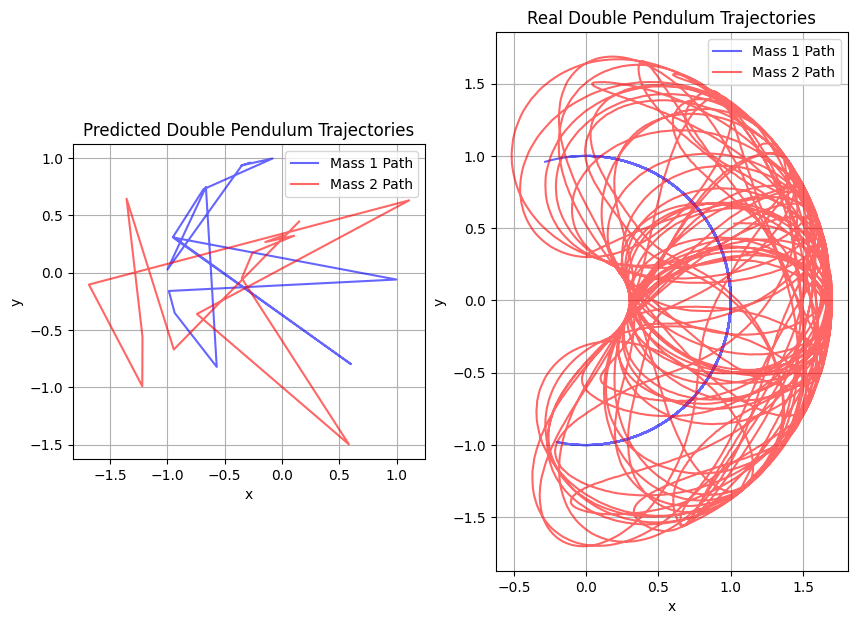

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x733ff6658310>>
Traceback (most recent call last):
  File "/home/julien2429/anaconda3/envs/py311/lib/python3.11/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/home/julien2429/anaconda3/envs/py311/lib/python3.11/site-packages/matplotlib/backend_bases.py", line 1152, in _on_timer
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/julien2429/anaconda3/envs/py311/lib/python3.11/site-packages/matplotlib/animation.py", line 1450, in _step
    still_going = super()._step(*args)
                  ^^^^^^^^^^^^^^^^^^^^
  File "/home/julien2429/anaconda3/envs/py311/lib/python3.11/site-packages/matplotlib/animation.py", line 1138, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/home/julien2429/anaconda3/envs/py311/lib/python3.11/site-packag

In [47]:
N = test_steps
Y = training_data[warm_steps+train_steps:]

l1 = 1.0  # Length of first pendulum
l2 = 0.7  # Length of second pendulum

fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(121)
ax.set_title("Generated pendulum")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.grid(False)

th1 = res[:, 0]
th2 = res[:, 1]
x1 = l1 * np.sin(th1)
y1 = -l1 * np.cos(th1)

x2 = x1 + l2 * np.sin(th2)
y2 = y1 - l2 * np.cos(th2)

cartesian_traj = np.stack([x1, y1, x2, y2], axis=1)  # shape: (n_timesteps, 4)

ax.plot(x1, y1, label='Mass 1 Path', color='blue', alpha=0.6)
ax.plot(x2, y2, label='Mass 2 Path', color='red', alpha=0.6)
ax.set_title("Predicted Double Pendulum Trajectories")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal')
ax.legend()
ax.grid(True)



ax2 = fig.add_subplot(122)
ax2.set_title("Real Double Pendulum Trajectories")
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")


th1 = Y[:, 0]
th2 = Y[:, 1]

x1 = l1 * np.sin(th1)
y1 = -l1 * np.cos(th1)

x2 = x1 + l2 * np.sin(th2)
y2 = y1 - l2 * np.cos(th2)

ax2.plot(x1, y1, label='Mass 1 Path', color='blue', alpha=0.6)
ax2.plot(x2, y2, label='Mass 2 Path', color='red', alpha=0.6)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_aspect('equal')
ax2.legend()
ax2.grid(True)




In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- Pendulum lengths ---
l1, l2 = 1.0, 0.7

# --- Trajectory Data (already computed) ---
# X = full trajectory
# res = generated
# Y = ground truth
# test_steps, train_steps, warm_steps already defined

N = test_steps
Y = X[warm_steps + train_steps:]

# --- Helper: Convert angles to positions ---
def get_positions(data):
    th1, th2 = data[:, 0], data[:, 1]
    x1 = l1 * np.sin(th1)
    y1 = -l1 * np.cos(th1)
    x2 = x1 + l2 * np.sin(th2)
    y2 = y1 - l2 * np.cos(th2)
    return x1, y1, x2, y2

# --- Get both trajectories in Cartesian coordinates ---
x1_res, y1_res, x2_res, y2_res = get_positions(res)
x1_true, y1_true, x2_true, y2_true = get_positions(Y)

# --- Set up figure and axes ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7))

for ax in (ax1, ax2):
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-2.5, 1.5)
    ax.set_aspect('equal')
    ax.grid(True)

ax1.set_title("Generated Pendulum")
ax2.set_title("Real Pendulum")

# --- Initialize lines ---
gen_line1, = ax1.plot([], [], 'o-', lw=2, color='blue')
gen_line2, = ax1.plot([], [], 'o-', lw=2, color='red')

true_line1, = ax2.plot([], [], 'o-', lw=2, color='blue')
true_line2, = ax2.plot([], [], 'o-', lw=2, color='red')

# --- Initialization function ---
def init():
    gen_line1.set_data([], [])
    gen_line2.set_data([], [])
    true_line1.set_data([], [])
    true_line2.set_data([], [])
    return gen_line1, gen_line2, true_line1, true_line2

# --- Update function for animation ---
def update(frame):
    # Generated
    gen_line1.set_data([0, x1_res[frame]], [0, y1_res[frame]])
    gen_line2.set_data([x1_res[frame], x2_res[frame]], [y1_res[frame], y2_res[frame]])

    # Real
    true_line1.set_data([0, x1_true[frame]], [0, y1_true[frame]])
    true_line2.set_data([x1_true[frame], x2_true[frame]], [y1_true[frame], y2_true[frame]])

    return gen_line1, gen_line2, true_line1, true_line2

# --- Create animation ---
ani = FuncAnimation(fig, update, frames=N, init_func=init, blit=True, interval=20)

plt.tight_layout()
plt.show()
